# Deep Bayesian Neural Networks for semi-supervised Representation Learning and Classification

## 1.Introduction

content goes here

In [1]:
# import all necessary libraries
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import (generator_xy, generator, 
                   load_data, accuracy, visulize,)
import edward as ed
import numpy as np
from AE import encoder, decoder, mlp, NN_classifier
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

## Data

content goes here

In [2]:
ed.set_seed(100)
sess = tf.InteractiveSession()
sess.as_default()
M = 12000
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_AE = load_data('../snp_gen/data/encoded_train_AE.pkl')
x_test_AE = load_data('../snp_gen/data/encoded_test_AE.pkl')
x_train_BAE = load_data('../snp_gen/data/encoded_train_BAE.pkl')
x_test_BAE = load_data('../snp_gen/data/encoded_test_BAE.pkl')
x_train_generator = generator_xy([x_train,y_train], M)
x_train_generator_AE = generator_xy([x_train_AE, y_train], M)
x_train_generator_BAE = generator_xy([x_train_BAE, y_train], M)

#### Data Visulization

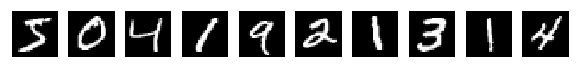

In [3]:
visulize(10, x_train)

## 2.Models 

content goes here

### Bayesian Autoencoder

Image of the model goes here

### Deep Bayesian Neural Network

In [4]:
# define model here
num_hidden = 100
D = 256
num_class = 10

W_0 = Normal(loc = tf.zeros([D, num_hidden]), scale = tf.ones([D, num_hidden]))
W_1 = Normal(loc = tf.zeros([num_hidden, num_class]), scale = tf.ones([num_hidden,num_class]))
b_0 = Normal(loc = tf.zeros(num_hidden), scale = tf.ones(num_hidden))
b_1 = Normal(loc = tf.zeros(num_class), scale = tf.ones(num_class))

x = tf.placeholder(tf.float32, [None, D])

y = Categorical(logits=NN_classifier(x, W_0, W_1, b_0, b_1))


In [5]:
# define the variational model here
qW_0 = Normal(loc = tf.Variable(tf.random_normal([D,num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,num_hidden]))))
qW_1 = Normal(loc = tf.Variable(tf.random_normal([num_hidden,num_class])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden,num_class]))))
qb_0 = Normal(loc = tf.Variable(tf.random_normal([num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden]))))
qb_1 = Normal(loc = tf.Variable(tf.random_normal([num_class])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_class]))))

## 3.Inference and Critisism

In [6]:
# inferece initilization for AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_AE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [7]:
# prior draw and prediction accuracy for AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))


training accuracy:
0.12776666666666667
testing accuracy:
0.1364


In [8]:
n_epoch = 100
n_iter_per_epoch = x_train_AE.shape[0] // M
loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_AE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        loss.append(-avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1


NameError: name 'log_loss' is not defined

In [ ]:
# training loss plot
plt.plot(range(n_epoch), loss)
plt.show()

In [ ]:
# posterior accuracy check for AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))

In [ ]:
# inferece initilization for Bayesian AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_BAE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [ ]:
# prior draw and prediction accuracy for Bayesian AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))


In [ ]:
n_epoch = 100
n_iter_per_epoch = x_train_BAE.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_BAE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        log_loss.append(-avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

In [ ]:
# posterior accuracy check for Bayesian AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))

In [ ]:
# training loss plot
plt.plot(range(n_epoch), loss)
plt.show()